# W207-1 Final Project - "Random Acts of Pizza"

## Team
- Andrew Mamroth
- Colby Carter
- Matt Adereth
- Rob Deng

[Team Github](https://github.com/mamrotha/2017_Fall_207_KaggleProj)

## Overview

[Original Kaggle Description](https://www.kaggle.com/c/random-acts-of-pizza)

There is a sub-reddit called [r/Random_Acts_Of_Pizza](https://www.reddit.com/r/Random_Acts_Of_Pizza/) where users can post requests for someone to purchase them a pizza and, shockingly, random internet strangers will then buy them pizza.  In this competition, we are provided with a data set containing over 5,000 posts from this sub-reddit and our goal is to build a model that can predict whether or not the post will result in a pizza purchase.

# Package Initialization

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import *
from sklearn.pipeline import Pipeline

import pandas as pd

# ADD METRICS
from sklearn import metrics
from sklearn.metrics import classification_report

#NLTK - NLP Tokenizing and Cleaning
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [3]:
# Only evaluate this if you don't already have the NLTK corpora
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

# Data 

## Original description of the data from the Kaggle website

This dataset includes 5671 requests collected from the Reddit community Random Acts of Pizza between December 8, 2010 and September 29, 2013 (retrieved on September 30, 2013). All requests ask for the same thing: a free pizza. The outcome of each request -- whether its author received a pizza or not -- is known. Meta-data includes information such as: time of the request, activity of the requester, community-age of the requester, etc.

Each JSON entry corresponds to one request (the first and only request by the requester on Random Acts of Pizza). We have removed fields from the test set which would not be available at the time of posting.

### Field Descriptions

| Field Name | Description |
| ---------- | ----------- |
| giver_username_if_known | Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise). |
| number_of_downvotes_of_request_at_retrieval | Number of downvotes at the time the request was collected. |
| number_of_upvotes_of_request_at_retrieval | Number of upvotes at the time the request was collected. |
| post_was_edited | Boolean indicating whether this post was edited (from Reddit). |
| request_id | Identifier of the post on Reddit, e.g. "t3_w5491". |
| request_number_of_comments_at_retrieval | Number of comments for the request at time of retrieval. |
| request_text | Full text of the request. |
| request_text_edit_aware | Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous". |
| request_title | Title of the request. |
| requester_account_age_in_days_at_request | Account age of requester in days at time of request. |
| requester_account_age_in_days_at_retrieval | Account age of requester in days at time of retrieval. |
| requester_days_since_first_post_on_raop_at_request | Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP). |
| requester_days_since_first_post_on_raop_at_retrieval | Number of days between requesters first post on RAOP and time of retrieval. |
| requester_number_of_comments_at_request | Total number of comments on Reddit by requester at time of request. |
| requester_number_of_comments_at_retrieval | Total number of comments on Reddit by requester at time of retrieval. |
| requester_number_of_comments_in_raop_at_request | Total number of comments in RAOP by requester at time of request. |
| requester_number_of_comments_in_raop_at_retrieval | Total number of comments in RAOP by requester at time of retrieval. |
| requester_number_of_posts_at_request | Total number of posts on Reddit by requester at time of request. |
| requester_number_of_posts_at_retrieval | Total number of posts on Reddit by requester at time of retrieval. |
| requester_number_of_posts_on_raop_at_request | Total number of posts in RAOP by requester at time of request. |
| requester_number_of_posts_on_raop_at_retrieval | Total number of posts in RAOP by requester at time of retrieval. |
| requester_number_of_subreddits_at_request | The number of subreddits in which the author had already posted in at the time of request. |
| requester_received_pizza | Boolean indicating the success of the request, i.e., whether the requester received pizza. |
| requester_subreddits_at_request | The list of subreddits in which the author had already posted in at the time of request. |
| requester_upvotes_minus_downvotes_at_request | Difference of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_minus_downvotes_at_retrieval | Difference of total upvotes and total downvotes of requester at time of retrieval. |
| requester_upvotes_plus_downvotes_at_request | Sum of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_plus_downvotes_at_retrieval | Sum of total upvotes and total downvotes of requester at time of retrieval. |
| requester_user_flair | Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83). |
| requester_username | Reddit username of requester. |
| unix_timestamp_of_request | Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA). |
| unix_timestamp_of_request_utc | Unit timestamp of request in UTC. |

## Initial Loading

In [51]:
# Load raw data and create labels
raw_train = pd.read_json('./data/train.json')
raw_test = pd.read_json('./data/test.json')

print "Raw Train Shape:", raw_train.shape
print "Raw Test Shape:", raw_test.shape

Raw Train Shape: (4040, 32)
Raw Test Shape: (1631, 17)


## Schema Reconciliation

The training data has 32 columns, while the test data only has 17.  Let's look at which columns are different:

In [50]:
raw_train_only_columns = set(raw_train.columns.values) - set(raw_test.columns.values)

if len(raw_train_only_columns) > 0:
    print "Columns in Train but not Test:"
    for c in raw_train_only_columns:
        print " ", c
else:
    print "No columns in Train but not Test"
    
raw_test_only_columns = set(raw_test.columns.values) - set(raw_train.columns.values)
print
if len(raw_test_only_columns) > 0:
    print "Columns in Test but not Train:"
    for c in raw_test_only_columns:
        print " ",c
else:
    print "No columns in Test but not Train"

Columns in Train but not Test:
  request_number_of_comments_at_retrieval
  requester_number_of_posts_on_raop_at_retrieval
  post_was_edited
  requester_upvotes_minus_downvotes_at_retrieval
  requester_received_pizza
  requester_account_age_in_days_at_retrieval
  requester_number_of_posts_at_retrieval
  requester_upvotes_plus_downvotes_at_retrieval
  number_of_upvotes_of_request_at_retrieval
  number_of_downvotes_of_request_at_retrieval
  request_text
  requester_user_flair
  requester_number_of_comments_in_raop_at_retrieval
  requester_days_since_first_post_on_raop_at_retrieval
  requester_number_of_comments_at_retrieval

No columns in Test but not Train


There are several columns that aren't included in the test data and thus need to be excluded from the training data.

- \*_at_retrival - These are features that are dependent on when the data was pulled.  For real-time prediction when a post is made, these are not relevant since they will be the same as their \*_at_request counterparts
- post_was_edited - Since users are supposed to edit their post if they receive a pizza, this would be a major leak of results.  Additionally, we want to be able to make predictions as soon as the post is made, so subsequent edits won't be available.
- requester_user_flair - There isn't historical flair information, so this feature isn't an accurate reflection of the state at the time of the request.  Users who successfully give or receive pizza are granted special flair, so this would also be an unfair indicator of results.
- request_text - Since successful posts are often edited to indicate that the request has been fulfilled, the full request_text can't be used.  The additional "request_text_edit_aware" field has edits stripped out and is available in both the train and test data and will be used instead.

In [9]:
train_with_test_schema = raw_train[raw_test.columns.values]

## Train/Development Data Split

We'll hold out ~15% of the training data as our development data set.  All exploratory data analysis and model training will be done only on the ~85% of training data that is not being held out.  We do not know if the order of the training data is meaningful, so we will use random sampling to avoid introducing bias.

In [43]:
np.random.seed(1)
in_dev = np.random.choice([True, False], len(raw_train), p=[0.15, 0.85])
train_data = train_with_test_schema[np.logical_not(in_dev)]
dev_data = train_with_test_schema[in_dev]

print "Training Rows:", len(train_data)
print "Dev Rows:", len(dev_data)

train_labels = raw_train["requester_received_pizza"][np.logical_not(in_dev)]
dev_labels = raw_train["requester_received_pizza"][in_dev]

Training Rows: 3450
Dev Rows: 590


## Exploratory Data Analysis
We'll now look at the individual fields to understand their types and distributions.

### Request Time
There are several things to look at with respect to the request time:

1. Has the frequency of requests changed over time?
2. Has the rate of request fulfillment changed over time?
3. Does day of week matter? (Possible new feature)
4. Does time of day matter? (Possible new feature)

#### Request Frequency

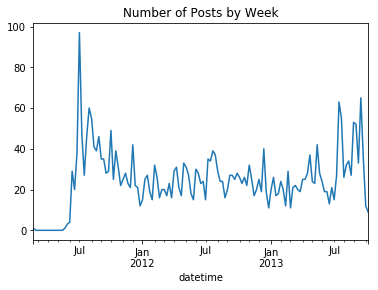

In [98]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_data["unix_timestamp_of_request"], unit = 's')
d.index = d['datetime']
d['datetime'].resample('W').count().plot().set_title('Number of Posts by Week')

#### Request Fulfillment over Time

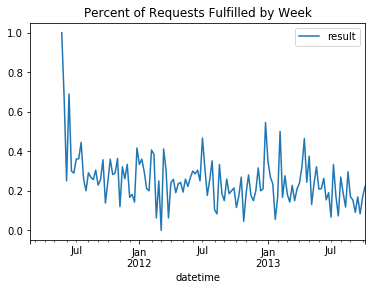

In [100]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_data["unix_timestamp_of_request"], unit = 's')
d['result'] = train_labels
d.index = d['datetime']
d.resample('W').mean().plot().set_title("Percent of Requests Fulfilled by Week")

It looks like there was a lot of excitement at the start of the sub-reddit.  There was a burst of requests and an unsustained high rate of fulfillment.  We may want to craft a feature that indicates whether or not the post was during this initial time, since it doesn't seem to be a part of the general trend.

#### Day of Week

In [116]:
d['dayofweek'] = d['datetime'].dt.dayofweek
d.groupby('dayofweek').agg(['mean', 'count'])

result      
               mean count
dayofweek                
0          0.267894   489
1          0.232246   521
2          0.229167   576
3          0.288503   461
4          0.259825   458
5          0.211111   450
6          0.232323   495

#### Time of Day

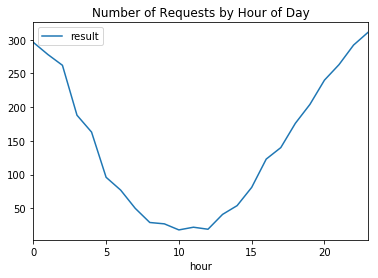

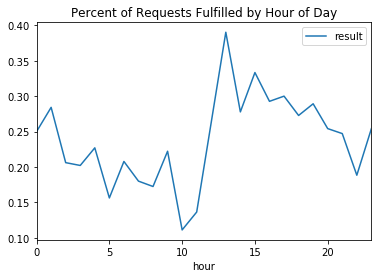

In [135]:
d['hour'] = d['datetime'].dt.hour
d[['hour', 'result']].groupby('hour').agg('count').plot().set_title("Number of Requests by Hour of Day")
d[['hour', 'result']].groupby('hour').agg('mean').plot().set_title("Percent of Requests Fulfilled by Hour of Day")

The fulfillment rate varies from 21.1% to 28.8% by the day of the week and from 11.1% to 39.0% depending on the hour of the day.  Both of these seem like reasonably distinguishing features that we should include.

### TODO: More EDA

# Modeling

In [6]:
#TRANSFORMATIONS & NEW FEATURES

# split labels
train_labels = raw_train["requester_received_pizza"]
train_data = raw_train.drop(['post_was_edited','requester_received_pizza'], 1) #edits not available in test data
test_data = raw_test 
print("orignial train shape:",train_data.shape)
print("test shape:",test_data.shape)


#get length of post
train_data["post_length"] = train_data["request_text_edit_aware"].apply(lambda x: len(x))
test_data["post_length"] = test_data["request_text_edit_aware"].apply(lambda x: len(x))
#print(train_data["post_length"].head(6))


# Create key quadratic terms for the following numeric variables:
# NOTE: variables "at_retrieval" are NOT available in the test dataset

#remove numeric vars pulled "at_retreival"
for col in train_data.columns.values:
    #print(col)
    if "retrieval" in col:
        train_data = train_data.drop(col, 1)


# form quadratic terms to capture curved relationship with log-odds
for_quad = ["requester_account_age_in_days_at_request", "requester_days_since_first_post_on_raop_at_request",
            "requester_number_of_comments_at_request", "requester_number_of_comments_in_raop_at_request",
            "requester_number_of_posts_at_request", "requester_number_of_subreddits_at_request",
            "requester_upvotes_minus_downvotes_at_request", "post_length"]

for col in for_quad:
    train_data[col + "_2"] = train_data[col]**2
    test_data[col + "_2"] = test_data[col]**2
print("new shapes:", train_data.shape, test_data.shape)


#transform requester_user_flair into two dummy variables for logistic
#TEST DATA DOES NOT CONTAIN THIS VARIABLE
#flair = ["shroom","PIF"]
#for f in flair:
    #train_data[f] = train_data["requester_user_flair"].apply(lambda x: 1 if x==f else 0)
    #test_data[f] = test_data["requester_user_flair"].apply(lambda x: 1 if x==f else 0)

    
#flag givers (very few givers who are also requesters)
successes = raw_train[raw_train['requester_received_pizza']==True]
givers = successes['giver_username_if_known']
known_givers = list(givers[givers != 'N/A'])

train_data["requester_giver"] = train_data["requester_username"].apply(lambda x: 1 if x in known_givers else 0)
test_data["requester_giver"] = test_data["requester_username"].apply(lambda x: 1 if x in known_givers else 0)
print(train_data[train_data["requester_giver"] == 1].shape)


#Here we split the number variables from the string type variables
text_columns = ['giver_username_if_known','request_id','request_text','request_text_edit_aware','request_title',
              'requester_subreddits_at_request','requester_user_flair','requester_username']
#for logistic regression
num_columns = [i for i in train_data.columns.values if i not in text_columns]
print("Numeric features:",num_columns)
col_names = list(train_data.columns.values)


('orignial train shape:', (4040, 30))
('test shape:', (1631, 17))
('new shapes:', (4040, 28), (1631, 26))
(3, 29)
('Numeric features:', [u'requester_account_age_in_days_at_request', u'requester_days_since_first_post_on_raop_at_request', u'requester_number_of_comments_at_request', u'requester_number_of_comments_in_raop_at_request', u'requester_number_of_posts_at_request', u'requester_number_of_posts_on_raop_at_request', u'requester_number_of_subreddits_at_request', u'requester_upvotes_minus_downvotes_at_request', u'requester_upvotes_plus_downvotes_at_request', u'unix_timestamp_of_request', u'unix_timestamp_of_request_utc', 'post_length', 'requester_account_age_in_days_at_request_2', 'requester_days_since_first_post_on_raop_at_request_2', 'requester_number_of_comments_at_request_2', 'requester_number_of_comments_in_raop_at_request_2', 'requester_number_of_posts_at_request_2', 'requester_number_of_subreddits_at_request_2', 'requester_upvotes_minus_downvotes_at_request_2', 'post_length_2',

In [7]:
# Create mini train and development set
dev_size = int(round(train_data.shape[0]*.15))

mini_train_data, mini_train_labels = train_data[dev_size:], train_labels[dev_size:]
print("Mini train size:",mini_train_data.shape, mini_train_labels.shape)

dev_data, dev_labels = train_data[:dev_size], train_labels[:dev_size]
print("Development set size:", dev_data.shape, dev_labels.shape)

('Mini train size:', (3434, 29), (3434,))
('Development set size:', (606, 29), (606,))


In [8]:
#Rob's Section

#Preprocess
def nltk_preprocess(data):
    stop = stopwords.words('english')
    
    #Merge title and request text together, lower string
    data['title_and_request'] = data[['request_text_edit_aware', 'request_title']].apply(lambda x: ''.join(x), axis=1).str.lower()
    #replacing sequences of numbers with a single token, removing various other non-letter characters, removing strings with underscores
    data['title_and_request'] = data['title_and_request'].apply(lambda x: re.sub(r'\d+', r' ', x)).apply(lambda y: re.sub(r'\W+', r' ', y)).apply(lambda z: re.sub(r"_+",r" ",z))
    #NLTK Tokenize
    data['tokenized_requests'] = data['title_and_request'].apply(word_tokenize)
    #NLTK Remove Stop Words i.e. the, an, etc
    data['tokenized_requests'] = data['tokenized_requests'].apply(lambda x: [item for item in x if item not in stop])
    #Word count of leftovers; didn't use this yet
    data['word_count'] = [len(data['tokenized_requests'][i]) for i in range(data.index[0], data.index[-1]+1)]
    #Rejoin after str split
    data['tokenized_requests'] = data['tokenized_requests'].apply(lambda x: ' '.join(x))
    return data['tokenized_requests']


def classify(model, model_parameters = False, use_tfidf=False):
    """Takes a model and parameters. 
       Outputs a classification report on the dev data, scored by f1_weighted.
       Prints out the best gridsearch parameter of choice."""
    if(use_tfidf):
        pipeliner = Pipeline([('cv', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('model', model())])
    else:
        pipeliner = Pipeline([("cv", CountVectorizer()), 
                              ("model", model())])

        #Make a simple prediction
    pipeliner.fit(processed_mini_train_data, mini_train_labels)
    pipeliner_pred = pipeliner.predict(processed_dev_data)
    print(model, "\n\n", "TFIDF = ", use_tfidf, "\n")
    print(classification_report(pipeliner_pred, dev_labels))
    return None


#process text entries
processed_mini_train_data = nltk_preprocess(mini_train_data)
processed_dev_data = nltk_preprocess(dev_data)
processed_test_data = nltk_preprocess(test_data)

classify(MultinomialNB, model_parameters = {"model__analyzer":"word", "model__ngram_range":(1,2)}, use_tfidf = True)
classify(MultinomialNB, model_parameters = {"model__analyzer":"word", "model__ngram_range":(1,2)}, use_tfidf = False)
classify(LogisticRegression, use_tfidf = True)
classify(LogisticRegression, use_tfidf = False)

/Users/madereth/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/madereth/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/madereth/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

(<class 'sklearn.naive_bayes.MultinomialNB'>, '\n\n', 'TFIDF = ', True, '\n')
             precision    recall  f1-score   support

      False       1.00      0.74      0.85       606
       True       0.00      0.00      0.00         0

avg / total       1.00      0.74      0.85       606



/Users/madereth/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(<class 'sklearn.naive_bayes.MultinomialNB'>, '\n\n', 'TFIDF = ', False, '\n')
             precision    recall  f1-score   support

      False       0.96      0.75      0.84       577
       True       0.07      0.38      0.12        29

avg / total       0.92      0.73      0.81       606

(<class 'sklearn.linear_model.logistic.LogisticRegression'>, '\n\n', 'TFIDF = ', True, '\n')
             precision    recall  f1-score   support

      False       0.99      0.74      0.85       598
       True       0.03      0.50      0.05         8

avg / total       0.98      0.74      0.84       606

(<class 'sklearn.linear_model.logistic.LogisticRegression'>, '\n\n', 'TFIDF = ', False, '\n')
             precision    recall  f1-score   support

      False       0.86      0.75      0.80       518
       True       0.17      0.30      0.21        88

avg / total       0.76      0.68      0.72       606



In [6]:
# Explore terms with the largest coefficients

def classify2(model, model_parameters = False, use_tfidf=False):
    """Takes a model and parameters. 
       Outputs a classification report on the dev data, scored by f1_weighted.
       Prints out the best gridsearch parameter of choice."""
    vec = CountVectorizer()
    train_feats = vec.fit_transform(processed_mini_train_data)
    train_vocab = vec.get_feature_names()
    print(len(train_vocab))
    dev_feats = vec.transform(processed_dev_data)
    
    lr =  LogisticRegression()
    #lr =  LogisticRegression(penalty="l1")
    lr.fit(train_feats, mini_train_labels)
    lr_preds = lr.predict(dev_feats)
    print(metrics.f1_score(dev_labels, lr_preds, average='micro'))
    print(classification_report(lr_preds, dev_labels))

    coefs = lr.coef_
    #print(coefs.shape)
    max_coefs = np.argsort(coefs, axis=1)[:,-30:]
    #print(max_coefs)
    top_features = []
    for i in range(max_coefs.shape[1]):
        #print(max_coefs[0][i])
        print(train_vocab[max_coefs[0][i]])


classify2(LogisticRegression, use_tfidf = False)

11507
0.681518151815
             precision    recall  f1-score   support

      False       0.86      0.75      0.80       518
       True       0.17      0.30      0.21        88

avg / total       0.76      0.68      0.72       606

expected
mentioned
projects
redding
relatives
denmark
state
christmas
gi
tucson
receive
drink
including
steam
lift
oatmeal
weather
ranch
loves
cookout
rather
eye
losing
except
topping
sunday
leg
zolo
hurting
father


In [9]:
#join numeric and vocabulary features

#use preprocessed vocab features
vec_full = CountVectorizer(stop_words = "english")
train_feats = vec_full.fit_transform(processed_mini_train_data)
train_vocab = vec_full.get_feature_names()
dev_feats = vec_full.transform(processed_dev_data)
test_feats = vec_full.transform(processed_test_data)

#make vocab arrays
train_vocab_ar = train_feats.toarray()
dev_vocab_ar = dev_feats.toarray()
test_vocab_ar = test_feats.toarray()
#new_array = np.array(train_feats)
print("Vocab train:", train_vocab_ar.shape)

#make numeric arrays
train_num_ar = mini_train_data[num_columns].as_matrix()
dev_num_ar = dev_data[num_columns].as_matrix()
test_num_ar = test_data[num_columns].as_matrix()
print("Numeric train:",train_num_ar.shape)

#join arrays into final feature sets
combined_train_feats = np.concatenate((train_vocab_ar,train_num_ar), axis = 1)
combined_dev_feats = np.concatenate((dev_vocab_ar,dev_num_ar), axis = 1)
combined_test_feats = np.concatenate((test_vocab_ar,test_num_ar), axis = 1)
print("Combined:",combined_train_feats.shape)
print("Test:",combined_test_feats.shape)

('Vocab train:', (3434, 11335))
('Numeric train:', (3434, 21))
('Combined:', (3434, 11356))
('Test:', (1631, 11356))


In [10]:
#Build a logistic model based on number value columns + preprocessed text field
# test with various values for C
full_lr = LogisticRegression(penalty="l1", C = .5)
full_lr.fit(combined_train_feats, mini_train_labels)
#full_lr.fit(train_feats, mini_train_labels)

#print(full_lr.coef_[0:20])

dev_preds = full_lr.predict(combined_dev_feats)
test_preds = full_lr.predict(combined_test_feats)
#dev_preds = full_lr.predict(dev_feats)
print(metrics.f1_score(dev_labels, dev_preds, average='micro'))
print(classification_report(dev_preds, dev_labels))

#test_preds = full_lr.predict(combined_test_feats)

test_out = pd.DataFrame()
test_out['request_id'] = test_data['request_id']
test_out['requester_received_pizza'] = test_preds.astype(int)
#num = sum(preds['requester_received_pizza'])

#print(num, sum(train_labels))

test_out.to_csv('./data/submission2.csv', index=False)

0.253521126761
             precision    recall  f1-score   support

      False       0.94      0.76      0.84       550
       True       0.17      0.48      0.25        56

avg / total       0.86      0.74      0.79       606



/Users/madereth/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [9]:
#Try looking at request only
train_text = mini_train_data['request_text_edit_aware']
dev_text = dev_data['request_text_edit_aware']
vec = CountVectorizer()
train_feats = vec.fit_transform(train_text)
train_vocab = vec.get_feature_names()
print(len(train_vocab))
vec2 = CountVectorizer(vocabulary=train_vocab)
dev_feats = vec2.transform(dev_text)

nb =  MultinomialNB()
nb.fit(train_feats, mini_train_labels)
nb_preds = nb.predict(dev_feats)
print(metrics.f1_score(dev_labels, nb_preds, average='micro'))
print(classification_report(nb_preds, dev_labels))

11244
0.729372937294
             precision    recall  f1-score   support

      False       0.97      0.74      0.84       589
       True       0.03      0.29      0.06        17

avg / total       0.95      0.73      0.82       606



In [11]:
#Try looking at request BIGRAMS only
train_text = mini_train_data['request_text_edit_aware']
dev_text = dev_data['request_text_edit_aware']
vec = CountVectorizer(analyzer="word", ngram_range=(1,2))
train_feats = vec.fit_transform(train_text)
train_vocab = vec.get_feature_names()
print(len(train_vocab))
vec2 = CountVectorizer(vocabulary=train_vocab)
dev_feats = vec2.transform(dev_text)

nb =  MultinomialNB()
nb.fit(train_feats, mini_train_labels)
nb_preds = nb.predict(dev_feats)
print(metrics.f1_score(dev_labels, nb_preds, average='micro'))
print(classification_report(nb_preds, dev_labels))

103097
0.0
             precision    recall  f1-score   support

      False       1.00      0.74      0.85       606
       True       0.00      0.00      0.00         0

avg / total       1.00      0.74      0.85       606



/Users/madereth/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
/Users/madereth/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
#Try looking at request TITLE only
train_text = mini_train_data['request_title']
dev_text = dev_data['request_title']
vec = CountVectorizer(analyzer="word", ngram_range=(1,2))
train_feats = vec.fit_transform(train_text)
train_vocab = vec.get_feature_names()
print(len(train_vocab))
vec2 = CountVectorizer(vocabulary=train_vocab)
dev_feats = vec2.transform(dev_text)

nb =  MultinomialNB()
nb.fit(train_feats, mini_train_labels)
nb_preds = nb.predict(dev_feats)
print(metrics.f1_score(dev_labels, nb_preds, average='micro'))
print(classification_report(nb_preds, dev_labels))

23071
0.0126582278481
             precision    recall  f1-score   support

      False       1.00      0.74      0.85       605
       True       0.01      1.00      0.01         1

avg / total       1.00      0.74      0.85       606



/Users/madereth/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [13]:
#Try looking at request only with TfidfVectorizer
train_text = mini_train_data['request_text_edit_aware']
dev_text = dev_data['request_text_edit_aware']
vec = TfidfVectorizer()
train_feats = vec.fit_transform(train_text)
train_vocab = vec.get_feature_names()
print(len(train_vocab))
vec2 = CountVectorizer(vocabulary=train_vocab)
dev_feats = vec2.transform(dev_text)

nb =  MultinomialNB()
nb.fit(train_feats, mini_train_labels)
nb_preds = nb.predict(dev_feats)
print(metrics.f1_score(dev_labels, nb_preds, average='micro'))
print(classification_report(nb_preds, dev_labels))

11244
0.0
             precision    recall  f1-score   support

      False       1.00      0.74      0.85       606
       True       0.00      0.00      0.00         0

avg / total       1.00      0.74      0.85       606



/Users/madereth/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:931: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [14]:
#NB weights of vocab without preprocessing step
# feature_log_prob_
print(nb.feature_log_prob_.shape)
max_weights = np.argsort(nb.feature_log_prob_, axis=1)[:,-20:]
print(max_weights)
print(max_weights[0])
for i in max_weights[0]:
    print(train_vocab[i])
print("**********")
for i in max_weights[1]:
    print(train_vocab[i])

(2, 11244)
[[ 9159  6925  1679 10022 11181  1206  5366  6201 10853 11088  4720  5376
   5149  7433  6867  4048  6570  9974   755 10126]
 [ 9159 11181 10022  6925  5366  1679  6201  1206 11088 10853  7433  4720
   5376  5149  6867  4048  6570  9974   755 10126]]
[ 9159  6925  1679 10022 11181  1206  5366  6201 10853 11088  4720  5376
  5149  7433  6867  4048  6570  9974   755 10126]
so
on
but
this
you
be
is
me
we
would
have
it
in
pizza
of
for
my
the
and
to
**********
so
you
this
on
is
but
me
be
would
we
pizza
have
it
in
of
for
my
the
and
to
